# Methyl Array Data Filter

## Where the data at?

In [1]:
input_path_450k = '../Data/Raw_Data/Methyl_Array_450k/'
input_path_EPIC = '../Data/Raw_Data/Methyl_Array_EPIC/'

# clinicaldata_path = '../Data/Raw_Data/Clinical_Data/'
# output_path = '../Data/Processed_Data/'

## Load Dataframes

In [2]:
import methylcheck

input_paths = [
    (input_path_EPIC, 'GSE190931'),      # COG_AAML1031
    (input_path_EPIC, 'GSE124413'),      # COG_AAML0531_03P1
    (input_path_EPIC, 'GSE133986'),      # Japanese AML-05
    (input_path_450k, 'GDC_TARGET-AML'), # AML_TARGET-450k
    (input_path_450k, 'GDC_TCGA-AML'),   # AML_TCGA
    (input_path_EPIC, 'GSE159907'),      # BeatAML
    (input_path_450k, 'GSE152710'),      # MDS_tAML
    (input_path_450k, 'GSE49031'),       # Nordic_ALL
    (input_path_EPIC, 'GDC_TARGET-ALL'), # ALL_TARGET
    (input_path_EPIC, 'GSE147667')       # Tcell_ALL_GRAAL
]

df = [methylcheck.load(path + name, silent=True) for path, name in input_paths]

## Merge Dataframes

In [3]:
import pandas as pd

# Concatenate the dataframes in the df list
df = pd.concat(df, keys= [name for _, name in input_paths] , axis=1, join='inner')

print(f' Dataset (df) contains {df.shape[0]} rows (5mC sites) and {df.shape[1]} columns (samples).')

 Dataset (df) contains 452453 rows (5mC sites) and 3845 columns (samples).


## Step 1. Remove Suboptimal Probes

There are several critera for exclusion of probes: Areas that have polymorphisms, cross-hybridization, repeat sequence elements, or base color changes can affect probe quality. 

Below are publications that have benchmarked probe quality and have provided lists of probes to exclude:

- [Chen2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3592906/), [Price2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3740789/), [Naeem2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3943510/), [DacaRoszak2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4659175/), [Zhou2016](https://academic.oup.com/nar/article/45/4/e22/2290930)

This function removes proves listed as sub-optimal according to:
    
    Zhou, W., Laird, P. W. & Shen, H.. Comprehensive characterization,
    annotation and innovative use of Infinium DNA methylation BeadChip probes.
    Nucleic Acids Research gkw967 (2016).
    doi:10.1093/nar/gkw967

For the .tsv file containing the annotated probes, download the paper's
supplementary material. See figure 5 of their paper for detailed description.

Please see function below `exclude_suboptimal_probes()` for paper information and where to find the annotations.

In [4]:
def exclude_suboptimal_probes(df):
    '''This function removes proves listed as sub-optimal according to:
    
    Zhou, W., Laird, P. W. & Shen, H.. Comprehensive characterization,
    annotation and innovative use of Infinium DNA methylation BeadChip probes.
    Nucleic Acids Research gkw967 (2016).
    doi:10.1093/nar/gkw967

    For the .tsv file containing the annotated probes, download the paper's
    supplementary material.
    '''
    zhou2016_probes = pd.read_csv('../Data/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv', sep='\t',index_col=0)

    unreliable_probes = list(zhou2016_probes[zhou2016_probes['MASK.general'] == True].index)

    df_ = df[~df.index.isin(unreliable_probes)]
    
    print(f'Removed {df.shape[0]-df_.shape[0]} suboptimal probes. {df_.shape[0]} remaining.')
    return(df_)

df = exclude_suboptimal_probes(df)

Removed 47382 suboptimal probes. 405071 remaining.


## Step 2. Remove sex-linked probes

In [5]:
df = methylcheck.exclude_sex_control_probes(df, '450k', no_sex=True, no_control=False, verbose=True)

450k: Removed 9570 sex-linked probes from 3845 samples. 395501 probes remaining.


## Evaluate Missing Values

Determining whether the data are missing completely at random (MCAR), missing at random (MAR), or missing not at random (MNAR) is an important aspect of handling missing data. Each of these missing data mechanisms has different implications for the choice of imputation method and the validity of the statistical inferences made from the data. Here are some methods to assess the missing data mechanism:

In [6]:
df_test = df.T.reset_index(drop=True)

<Axes: >

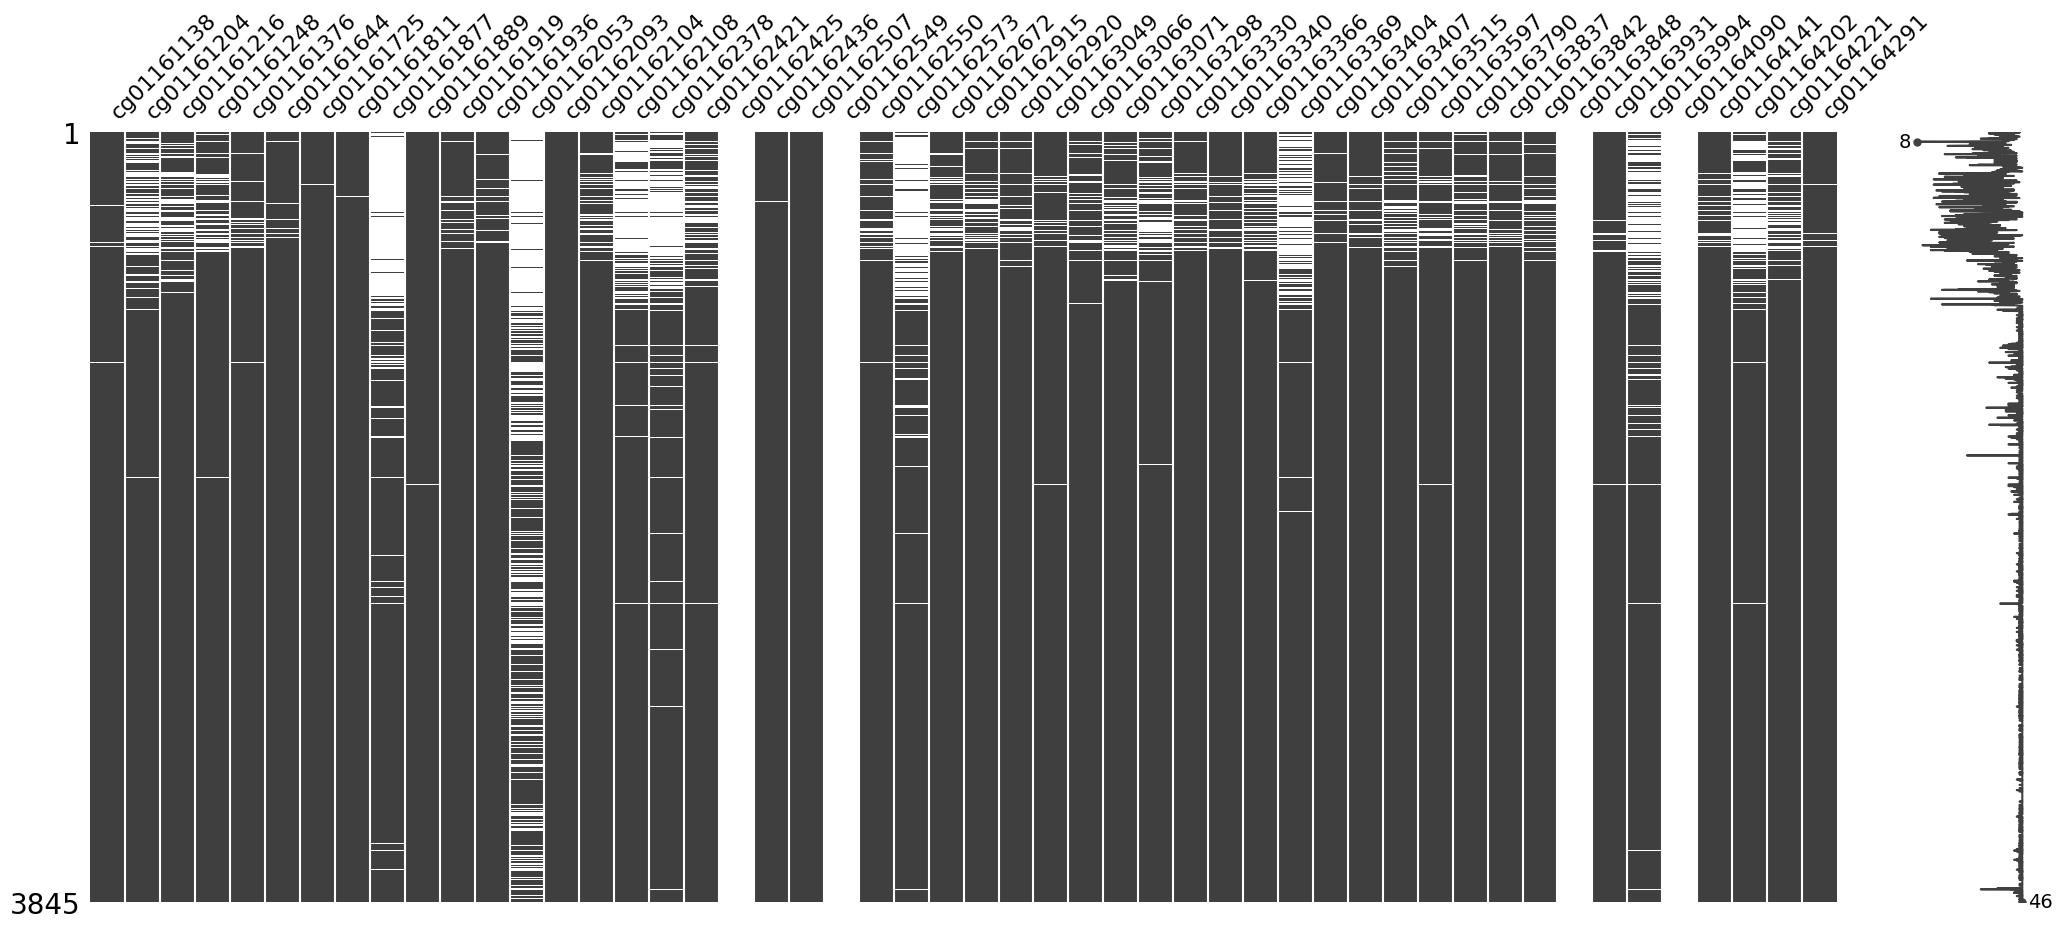

In [7]:
import missingno as msno

msno.matrix(df_test.iloc[:,20000:20050])

## Step 3. Exclude samples in which >20% of probes have failed p-values

A strict metric implemented by Illumina quality control process is `FAIL by pval`, which happens if, for a given sample, the detection p-value is >0.05 in >20% of probes.

Recall that detection p-values measure how likely it is that signals are background fluorescence. There are a few methods for calculating these:  ```SeSAMe``` and ```methylprep``` implement pOOBAH, which stands for P-value Out Of Band (OOB) probes for Array Hybridization. For more, see [SeSAMe paper](https://pubmed.ncbi.nlm.nih.gov/30085201/).

In other words, we will exclude samples that Illumina QC categorizes as FAIL(pval) for meeting the condition: (pOOBAH > 0.05) >20% probes. Here, failed probes are listed as `NaN`, so we will count the number of `NaN` values in each sample and exclude samples that have more than 20% `NaN` values.

In [8]:
def exclude_failed_samples(df2):
    '''This function removes samples that have more than 20% NaN values.'''

    # Calculate the number of NaN values in each sample
    nan_count = df2.isna().sum()

    # Calculate the total number of probes (rows) in the DataFrame
    total_probes = df2.shape[0]

    # Calculate the percentage of NaN values for each sample
    nan_percentage = (nan_count / total_probes) * 100

    # Identify samples that meet the condition of having more than 20% NaN values
    samples_to_exclude = nan_percentage[nan_percentage > 20].index

    # Exclude samples that meet the condition from the DataFrame
    filtered_df2 = df2.drop(samples_to_exclude, axis=1)
    
    # Print the number of samples before and after filtering
    print(
    f"Removed {df2.shape[1]-filtered_df2.shape[1]} samples ({round((df2.shape[1]-filtered_df2.shape[1])/df2.shape[1]*100,2)}%). {filtered_df2.shape[1]} samples remaining."
    )
    
    return filtered_df2

df = exclude_failed_samples(df)


Removed 466 samples (12.12%). 3379 samples remaining.


## Step 4. Exclude CpG probes that are missing in more than 20% of samples

In [9]:
def probe_cutoff(qc_betas, threshold):
    qc_betas2 = qc_betas.dropna(axis=0, thresh = int(threshold*qc_betas.shape[1]))
    print(f'{qc_betas.shape[0] - qc_betas2.shape[0]} probe(s) removed. {qc_betas2.shape[0]} probes remaining.')

    return(qc_betas2)

df = probe_cutoff(df, threshold=0.80)

28107 probe(s) removed because of >20% missing values. 367394 probes remaining.


In [10]:
df_test2 = df.T.reset_index(drop=True)

<Axes: >

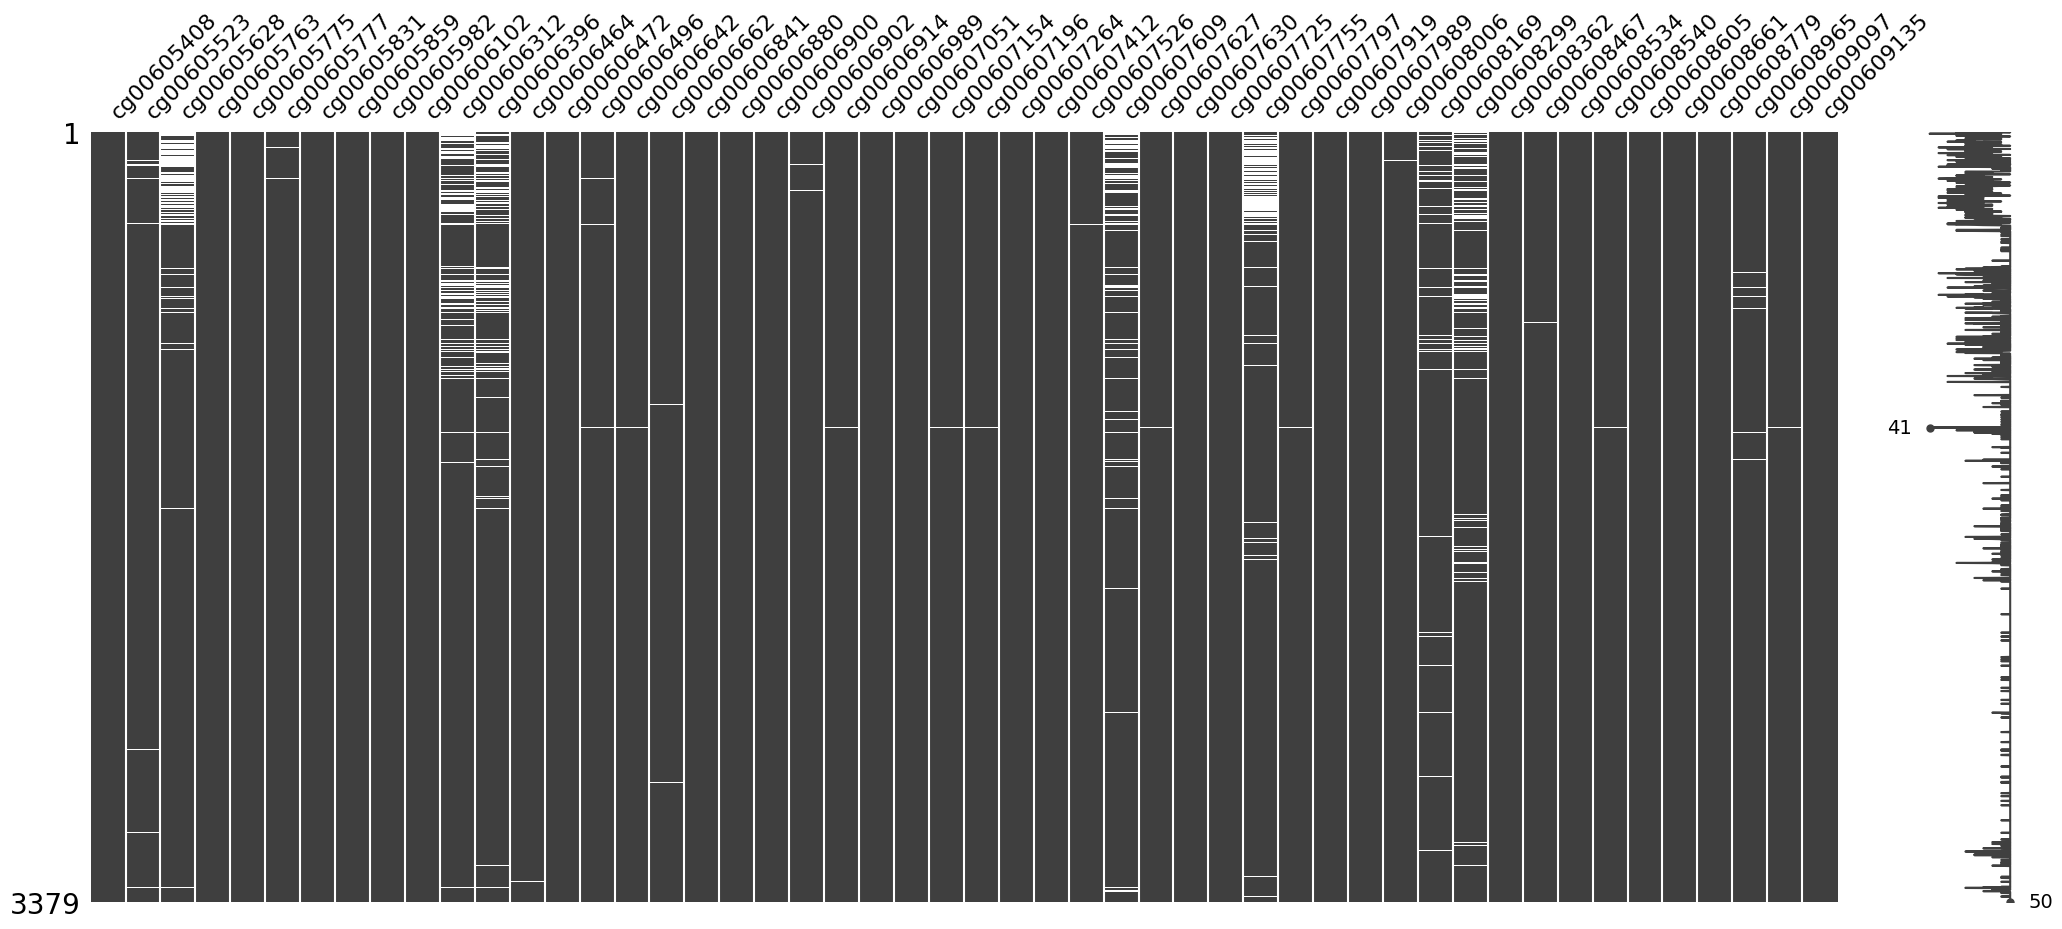

In [12]:
msno.matrix(df_test2.iloc[:,10000:10050])

In [13]:
df

GSE190931                                           
               202897270043_R01C01 202897270043_R03C01 202897270043_R04C01   
IlmnID                                                                       
cg00000029                     NaN               0.720               0.867  \
cg00000109                   0.932               0.962               0.881   
cg00000165                   0.101               0.588               0.157   
cg00000236                   0.838               0.822               0.904   
cg00000292                   0.893               0.899               0.736   
...                            ...                 ...                 ...   
ch.9.898515R                 0.077               0.045                 NaN   
ch.9.90287778F               0.068               0.027               0.053   
ch.9.90621653R               0.043               0.027               0.051   
ch.9.93402636R               0.036               0.025               0.044   
ch.9.98463211R               0.043               0.030               0.044   

                                                                             
               202897270043_R05C01 202897270043_R06C01 202897270043_R07C01   
IlmnID                                                                       
cg00000029                     NaN               0.575                 NaN  \
cg00000109                   0.876               0.924               0.951   
cg00000165                   0.625                 NaN               0.674   
cg00000236                     NaN               0.674                 NaN   
cg00000292                   0.219               0.683               0.632   
...                            ...                 ...                 ...   
ch.9.898515R                   NaN                 NaN               0.066   
ch.9.90287778F               0.066               0.038               0.054   
ch.9.90621653R               0.048               0.037               0.044   
ch.9.93402636R               0.059               0.035               0.041   
ch.9.98463211R               0.122               0.054               0.041   

                                                                             
               202897270043_R08C01 202897270045_R03C01 202897270045_R04C01   
IlmnID                                                                       
cg00000029                   0.854                 NaN                 NaN  \
cg00000109                   0.885                 NaN               0.960   
cg00000165                     NaN               0.565               0.160   
cg00000236                     NaN               0.877               0.945   
cg00000292                   0.920               0.776               0.930   
...                            ...                 ...                 ...   
ch.9.898515R                   NaN                 NaN               0.079   
ch.9.90287778F               0.063               0.052               0.066   
ch.9.90621653R               0.046               0.045               0.068   
ch.9.93402636R               0.062               0.041               0.056   
ch.9.98463211R               0.065               0.049               0.035   

                                    ...           GSE147667   
               202897270045_R06C01  ... 201233760140_R05C01   
IlmnID                              ...                       
cg00000029                     NaN  ...               0.901  \
cg00000109                   0.943  ...               0.923   
cg00000165                     NaN  ...               0.125   
cg00000236                   0.262  ...               0.939   
cg00000292                   0.732  ...               0.912   
...                            ...  ...                 ...   
ch.9.898515R                 0.055  ...               0.037   
ch.9.90287778F               0.052  ...               0.032   
ch.9.90621653R               0.030  ...              

## Step 5. Impute remaining missing values


We still have probes with missing values that are below our 5% threshold. To fix that, we interpolate remaining beta values values linearly.
- Linear interpolation means that a missing mC value for a particular sample will be filled with the median of the values of the two adjacent samples. The reason behind this is the high concordance _usually_ seen in the methylation profile of neighboring samples.
- Inevitably, this step adds arbitration to the data cleaning process.

In [21]:
# df5 = df4.interpolate(axis=0).interpolate(axis=0, limit_direction='backward').round(3)

# print(f' Interpolated dataset contains {df3.shape[0]}'
# + f' rows (5mC probes) and {df3.shape[1]} columns (samples).')

 Interpolated dataset contains 395501 rows (5mC probes) and 2196 columns (samples).


In [23]:
df_methyl = df3.T.reset_index(level=0, names='Batch')

print(
    f' Dataset (df) contains {df_methyl.shape[1]} rows (mC sites) and {df_methyl.shape[0]} columns (samples).')

 Dataset (df) contains 395502 rows (mC sites) and 2196 columns (samples).


## Add Labels/Clinical Outcome Data

In [24]:
# Import functions to clean up clinical data
from FM_Functions.Clinical_Data_CleanUp import *

# Combine all clinical data files into one dataframe and indexes it by the sample ID
labels_cog, labels_aml02, labels_aml08, labels_aml05 = combine_and_index_clinicaldata()

# Clean up and adjust clinical data labels
labels_aml02 = clean_aml02(labels_aml02)
labels_aml08 = clean_aml08(labels_aml08)
labels_cog   = clean_cog(labels_cog)
labels_aml05 = clean_aml05(labels_aml05)

# Combine all clinical data labels
df = pd.concat([labels_aml02, labels_aml08, labels_cog,
               labels_aml05], axis=0, join='outer')

# Remove samples that are not in the methyl dataset
df = df.loc[df.index.isin(df_methyl.index)]

# Label control samples from the AML0531 clinical trial (GSE124413) as 'Bone Marrow Normal'

def label_control_samples(df_methyl, df):
    """
    This function labels control samples from the AML0531 clinical trial (GSE124413) as 'Bone Marrow Normal'
    and combines them with the clinical trial samples.
    """
    a = df_methyl[df_methyl['Batch'].isin(['GSE124413_AAML0531'])]
    b = df[df.index.isin(a.index)]
    control_0531 = a[~a.index.isin(b.index)]
    control_0531['Sample Type'] = 'Bone Marrow Normal'
    df_ = pd.concat(
        [df, control_0531['Sample Type'].to_frame()], axis=0, join='outer')
    return df_

df_ = label_control_samples(df_methyl, df)


## BeatAML Clinical Data

In [39]:
import pandas as pd
meta = pd.read_pickle('../Data/Raw_Data/GSE159907_BeatAML/GSE159907_GPL21145_meta_data.pkl')
# Create a new column with only the content inside [] from column 'Sample_Name'
meta['LLS_SampleID'] = meta['Sample_Name'].str.extract(r"\[(.*?)\]", expand=False)

# Set the index to the new column
meta1 = meta[['tissue','disease state','LLS_SampleID']].set_index('LLS_SampleID')

# Capitalize column names
meta1.columns = meta1.columns.str.capitalize()

# Read in the clinical data
meta2 = pd.read_excel('../Data/Raw_Data/Clinical_Data/BeatAML/BEAT_AML_Raw clinical data_702.Samples.Vizome.xlsx', index_col=3)

# Join the two dataframes
meta3 = meta1.join(meta2, how='left')

## Save Dataset

In [11]:
output_path = '../Data/Processed_Data/Methyl_Array_Processed/'

df5.to_pickle(output_path + '2_MethylData_Processing_Output.pkl')

print(
    f'Successfuly saved processed methyl dataset.\nPath: {output_path}')


Successfuly saved processed methyl dataset.
Path: ../Data/Processed_Data/Methyl_Array_Processed/


## Watermark

In [12]:
%load_ext watermark

In [13]:
%watermark -v -p methylcheck,pandas

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.34.0

methylcheck: 0.8.5
pandas     : 1.3.5

